In [1]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(1, '/Users/richard/Documents/projects/py_learning/sussex/Dissertation/gym')

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

In [2]:



def getGoalIndices(desc):
    """
    find the indexes of the goals from the environment description
    """
    q_index=0
    goal_indices = []
    for i in desc:
        for j in range(len(i)):
            if i[j]=="G":
                goal_indices.append(q_index)
            q_index +=1
    
    return goal_indices

    

In [3]:
def getGoalCoordinates(index, observation_space_size):
    side = int(np.sqrt(observation_space_size))
    x= index%side
    y= int(np.floor(index/side))

    return x, y
    
def generate_random_map_extended(goalIndices: list = None, size: int = 8, p: float = 0.8):
    
    def update_cell(desc, x, y , new_value):
        row = desc[y]
        row_as_list = [row[i] for i in range(len(row))]
        row_as_list[x] = new_value 
        desc[y] = "".join(row_as_list)
        return desc


    # generate a random map with start at [0,0] and goal at [-1, -1]
    desc = generate_random_map(size, p)

    if goalIndices != None:

        desc = update_cell(desc, size-1, size-1, "F") # set the default Goal to frozen
        
        #overwrite the default goal position if goal indices given
        for index in goalIndices:
            x, y = getGoalCoordinates(index, np.square(size))
            desc = update_cell(desc, x, y, "G") # set the cell to be a goal
            
            

    return desc


In [4]:


# desc = [
#     "SFFFFFFF",
#     "FFFFFFFF",
#     "FFFHFFFG",
#     "FFFFFHFF",
#     "FFFHFFFF",
#     "FHHGFFHF",
#     "FHFFHFHF",
#     "FFFHFFFF",
# ]

desc = generate_random_map_extended([299], size=19, p=0.9)


goalIndices = getGoalIndices(desc)


env = gym.make('FrozenLake-v1', is_slippery=False, map_name="8x8", desc=desc)

In [5]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(361)


In [6]:
actionsDict = {}
actionsDict[0] = " L "
actionsDict[1] = " D "
actionsDict[2] = " R "
actionsDict[3] = " U "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [7]:
env.reset()
env.render()

In [8]:
# optimalPolicy = ["R/D"," R "," D "," L ",
#                  " D "," - "," D "," - ",
#                  " R ","R/D"," D "," - ",
#                  " - "," R "," R "," ! ",]
    
# print("Optimal policy:")
# idxs = [0,4,8,12]
# for idx in idxs:
#     print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
#           optimalPolicy[idx+2], optimalPolicy[idx+3])

In [9]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [10]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [11]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 500
    for i in range(n):
        done = False
        s = env.reset()
        while not done:
            a = policy_fct(q, s)
            s, reward, done, info = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [12]:
# parameters for sarsa(lambda)
episodes = 30000
STEPS = 500
gamma = 0.9
alpha = 0.05
epsilon_start = 0.2
epsilon_end = 0.001
epsilon_annealing_stop = int(episodes/2)
eligibility_decay = 0.3

In [13]:

q = np.ones((env.observation_space.n, env.action_space.n))
# Set q(terminal,*) equal to 0

q_index=0
for i in desc:
    for j in range(len(i)):
        if i[j] =="H" or i[j]=="G":
            q[q_index,:] = 0.0
        q_index +=1

performance = np.ndarray(episodes//STEPS)

In [14]:
def resolveActionState(actionState):

    index = np.argmax(actionState)

    if index == 0: #left
        vertical = 0
        horizontal = actionState[index] *-1
    elif index == 1: #down
        vertical = actionState[index] *-1
        horizontal = 0
    elif index == 2: #right
        vertical = 0
        horizontal = actionState[index]
    elif index == 3: #up
        vertical = actionState[index]
        horizontal = 0
        
    return horizontal, vertical
    

In [15]:
from IPython.display import display, clear_output


def plotActionStateQuiver():

    dim=int(np.sqrt(env.observation_space.n))    
    fig1, ax1 = plt.subplots(figsize=(10,10))
    
    policyFound = [resolveActionState(q[x,:]) for x in range(env.observation_space.n)]
    
    
    i = np.arange(0,dim) #rows
    j = np.arange(0,dim) #colums

    ii, jj = np.meshgrid(i,j)#, indexing='ij')

    # print("row indices:\n{}\n".format(ii))
    # print("column indices:\n{}".format(jj))

    U = np.reshape([i[0] for i in policyFound], (dim, dim))
    V = np.reshape([i[1] for i in policyFound], (dim, dim))

    ax1.cla()

    ax1.scatter([0],[0], c='g', s=500, marker='^') #origin

    for index in goalIndices:
        x, y = getGoalCoordinates(index, env.observation_space.n)
        ax1.scatter([x],[y], c='r', s=500, marker='o') #goal
        
    QP = ax1.quiver(ii,jj, U, V)
    plt.gca().invert_yaxis()
    # 
    # ax.set_aspect('equal')
    # plt.grid()
    # plt.show()
    # drawing updated values

    display(fig1)    
    clear_output(wait = True)
    # ax.clear()
    plt.pause(0.1)
    

In [16]:

for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E = np.zeros((env.observation_space.n, env.action_space.n))
    
    state = env.reset()
    action = action_epsilon_greedy(q, state, epsilon)

    while True:

        E = eligibility_decay * gamma * E
        E[state, action] += 1
        
        new_state, reward, done, info = env.step(action)
        
        new_action = action_epsilon_greedy(q, new_state, epsilon)

        delta = reward + gamma * q[new_state, new_action] - q[state, action]
        q = q + alpha * delta * E 

        state, action = new_state, new_action

        if done:
            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        performance[episode//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=q)

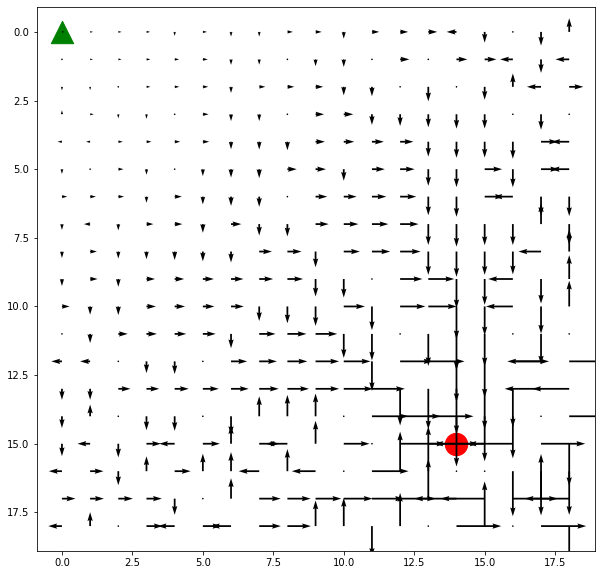

In [17]:
plotActionStateQuiver()

Text(0, 0.5, 'Average reward of an epoch')

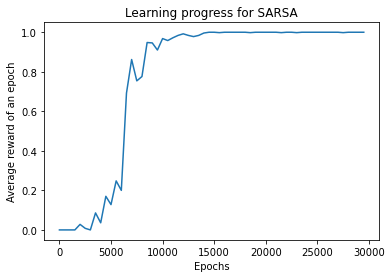

In [18]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [19]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=q)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 1.0


In [20]:
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:8,:])
print("Second row")
print(q[8:16,:])
print("Third row")
print(q[16:24,:])
print("Fourth row")
print(q[24:32,:])
print("Fith row")
print(q[32:40,:])
print("Six row")
print(q[40:48,:])
print("Seventh row")
print(q[48:56,:])
print("Eighth row")
print(q[56:64,:])

(A,S) Value function = (361, 4)
First row
[[0.043 0.    0.052 0.042]
 [0.043 0.05  0.058 0.048]
 [0.048 0.057 0.064 0.053]
 [0.054 0.066 0.072 0.06 ]
 [0.059 0.08  0.07  0.066]
 [0.067 0.077 0.081 0.072]
 [0.078 0.094 0.085 0.082]
 [0.089 0.093 0.091 0.091]]
Second row
[[0.103 0.029 0.108 0.104]
 [0.117 0.119 0.12  0.118]
 [0.13  0.134 0.131 0.131]
 [0.144 0.099 0.144 0.144]
 [0.156 0.159 0.159 0.157]
 [0.177 0.166 0.177 0.177]
 [0.196 0.196 0.196 0.194]
 [0.214 0.214 0.204 0.213]]
Third row
[[0.    0.    0.    0.   ]
 [0.238 0.273 0.272 0.272]
 [0.272 0.271 0.268 0.272]
 [0.    0.    0.    0.   ]
 [0.    0.055 0.057 0.052]
 [0.061 0.017 0.065 0.06 ]
 [0.061 0.067 0.077 0.063]
 [0.066 0.08  0.088 0.066]]
Fourth row
[[0.074 0.09  0.098 0.071]
 [0.083 0.109 0.094 0.079]
 [0.101 0.106 0.054 0.097]
 [0.    0.    0.    0.   ]
 [0.081 0.136 0.132 0.133]
 [0.148 0.151 0.063 0.147]
 [0.    0.    0.    0.   ]
 [0.175 0.175 0.184 0.182]]
Fith row
[[0.    0.    0.    0.   ]
 [0.215 0.215 0.216 0.

In [21]:
def resolveActionDict(x, actionState):
    if x in goalIndices:
        return " ! "
    elif all(v == 0 for v in actionState):
        return " - "
    else:
        return actionsDict[np.argmax(actionState)]
    

In [22]:

policyFound = [resolveActionDict(x, q[x,:]) for x in range(env.observation_space.n)]

print("Greedy policy found:")
idxs = np.arange(0, env.observation_space.n, int(np.sqrt(env.observation_space.n)))
for idx in idxs:
    row = []
    for i in range(int(np.sqrt(env.observation_space.n))):
        row.append(policyFound[idx+i])
    print(','. join(row))
        
print(" ")

# print("Optimal policy:")
# idxs = [0,4,8,12]
# for idx in idxs:
#     print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
#           optimalPolicy[idx+2], optimalPolicy[idx+3])

Greedy policy found:
 R , R , R , R , D , R , D , D , R , R , D , L , D , L , L , L , - , D , L 
 - , R , R , R , R , R , D , D , - , D , D , - , R , - , R , R , L , D , L 
 D , L , - , R , R , R , D , R , R , R , D , D , - , D , - , D , R , L , R 
 U , D , D , D , - , R , D , D , - , D , R , D , D , D , D , L , - , D , - 
 L , L , R , R , L , R , D , D , D , L , R , R , R , D , D , D , D , D , L 
 D , - , D , L , - , D , D , D , R , R , D , R , R , D , D , D , D , R , L 
 L , D , D , D , D , D , D , D , - , D , R , R , R , D , D , R , L , D , D 
 D , L , D , D , L , D , R , D , D , R , R , R , R , D , D , L , D , U , D 
 L , D , L , D , D , D , D , R , R , D , R , R , R , D , D , L , L , L , U 
 L , D , D , L , R , R , R , R , R , D , D , - , R , R , D , D , L , D , L 
 R , D , L , D , R , L , R , D , D , D , R , D , R , R , D , D , L , D , U 
 - , D , L , R , R , R , D , R , R , R , D , D , - , D , D , D , - , D , - 
 L , L , - , D , D , - , R , D , R , R , R , D , R , R , D , D , R 